## 6.1 Deep Dream模型
	卷积神经网络取得了突破性进展，效果也非常理想，但其过程一直像谜一样困扰大家。为了揭开卷积神经网络的神秘面纱，人们探索了多种方法，如把这些过程可视化。但是，卷积神经网络是如何学习特征的？这些特征有哪些作用？如何可视化这些特征？这正是Deep Dream解决的问题。
### 6.1.1 Deep Dream的原理
Deep Dream为了说明CNN学习到的各特征的意义，将采用放大处理的方式。具体来说就是使用梯度上升的方法可视化网络每一层的特征，即用一张噪声图像输入网络，在反向更新时不更新网络权重，而是更新初始图像的像素值，以这种“训练图像”的方式来可视化网络。
Deep Dream是如何放大图像特征的？这里我们先看一个简单实例。比如有一个网络学习了分类猫和狗的任务，给这个网络一张云的图像，这朵云可能比较像狗，那么机器提取的特征可能也会像狗。假设一个特征最后的输入概率为[0.6, 0.4]，0.6表示为狗的概率，0.4表示为猫的概率，那么采用L2范数可以很好地达到放大特征的效果。对于这样一个特征，L2 =〖x1〗^2+〖x2〗^2，若x1越大，x2越小，则L2越大，所以只需要最大化L2就能保证当x1>x2时，迭代的轮数越多x1越大，x2越小，即图像就会越来越像狗。每次迭代相当于计算一次L2范数，然后用梯度上升的方法调整图像。优化的不再是权重参数，而是特征值或像素点，因此，在构建损失函数时，我们不使用通常的交叉熵，而是使用最大化特征值的L2范数，使图像经过网络之后提取的特征更像网络隐含的特征。
以上是Deep Dream的基本原理，具体实现的时候还要通过多尺度、随机移动等方法获取比较好的结果。后续在代码部分会给出详细解释。

### 6.1.2 Deep Dream算法的流程
将基本图像输入预训练的CNN中，然后正向传播到特定层。为了更好地理解该层学到了什么，我们需要最大化该层的激活值。以该层输出为梯度，然后在输入图像上完成渐变上升，以最大化该层的激活值。不过，仅这样做并不能产生好的图像。为了提高训练质量，我们还需要使用一些技术使得到的图像更好。 可以进行高斯模糊以使图像更平滑，也可以使用多尺度（又称为八度）的图像进行计算。即先连续缩小输入图像，然后再逐步放大，并将结果合并为一个图像输出。
我们把上面过程用图6-1来说明。
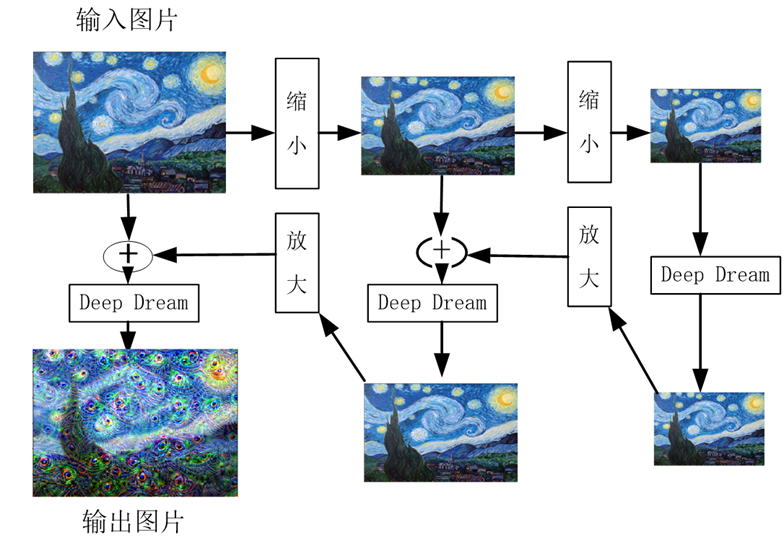
<center>图6-1 Deep Dream 流程图</center>
	先对图像连续做两次等比例缩小，该比例是1.5，缩小图像是为了让图像的像素点调整后所得结果图案能显示得更加平滑。缩小两次后，把图像的每个像素点当作参数，对它们求偏导，这样就可以知道如何调整图像像素点，以使给定网络层的输出受到最大化的刺激。

### 6.1.3 使用PyTorch实现Deep Dream
使用Deep Dream须解决两个问题，如何获取有特殊含义的特征以及如何表现这些特征？
针对第一个问题，我们通常使用预训练模型，这里取vgg19预训练模型。针对第二个问题，可以把这些特征最大化后展示在一张普通的图像上，该图像为星空图像。
为了使训练更有效，我们还需使用一点小技巧，即对图像进行不同大小的缩放，并对图像进行模糊或抖动等处理。
注意，这里需要下载预训练模型及两个函数，一个是prod，另一个是deep_dream_vgg。下面来看具体实现过程。 
1）导入模块及下载预训练模型。

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [2]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    images=image * torch.tensor([0.229, 0.224, 0.225],device=device)  + torch.tensor([0.485, 0.456, 0.406],device=device)
    return  images


In [3]:
#下载预训练模型vgg19
vgg = models.vgg19(pretrained=True)
vgg = vgg.to(device)
print(vgg)
modulelist = list(vgg.features.modules())

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\wumgapp/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

2）定义函数prod。  
	prod属于deep-dream代码，传入输入图像，正向传播到VGG19的指定层（如第8层或第32层等），然后，用梯度上升更新输入图像的特征值。详细代码如下：

In [4]:
def prod(image, layer, iterations, lr):   
    input = preprocess(image).unsqueeze(0)
    input=input.to(device).requires_grad_(True)
    vgg.zero_grad()
    for i in range(iterations):
        out = input
        for j in range(layer):
            out = modulelist[j+1](out)
        #以特征值的L2为损失值    
        loss = out.norm()
        loss.backward()
        #使梯度增大
        with torch.no_grad():
            input += lr * input.grad
            
    
    input = input.squeeze()
    #交互维度
    input.transpose_(0,1)
    input.transpose_(1,2)
    #使数据限制在[0,1]之间
    input = np.clip(deprocess(input).detach().cpu().numpy(), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im


3）定义函数deep_dream_vgg。  
	deep_dream_vgg是一个递归函数，多次缩小图像，然后调用函数prod。接着放大输出结果，并与按一定比例与相应图像混合在一起（如图16-1所示），最终得到与输入图像相同大小的输出图像。详细代码如下：

In [5]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale=2, num_octaves=20):
    
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
            
        else:            
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
        #缩小图片    
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        
        size = (image.size[0], image.size[1])
        #放大图片
        image1 = image1.resize(size,Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)

    img_result = prod(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

4）	输入图像，并查看运行结果。

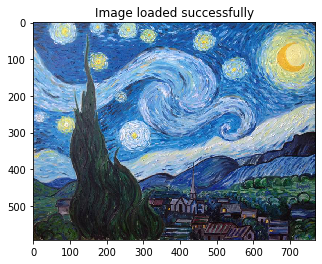

In [6]:
night_sky = load_image('starry_night.jpg')

查看VGG19的第32层图像：

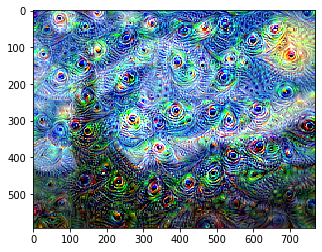

In [7]:
night_sky_32 = deep_dream_vgg(night_sky, 32, 6, 0.2)

查看VGG19的第8层的图像

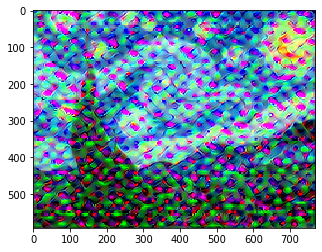

In [8]:
night_sky_8 = deep_dream_vgg(night_sky, 8, 6, 0.2)